# Isotropic Scaling Experiment

## Synopsis

In this experiment, I will be looking at how the isotropic scaling effects the HSIC score for the HSIC and KA algorithms. In theory, because we are trying to find one parameter shared between the two kernel functions, there should be problems when the scale of one distribution is larger than another. It's a drawback of the method and it motivates the need to use two different parameters for the distributions.

## Code

In [1]:
import sys, os
# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

import warnings
import tqdm
import random
import pandas as pd
import numpy as np
import argparse
from sklearn.utils import check_random_state

# toy datasets
from data.toy import generate_dependence_data, generate_isotropic_data

# Kernel Dependency measure
from models.train_models import get_gamma_init
from models.train_models import get_hsic
from models.kernel import estimate_sigma, sigma_to_gamma, gamma_to_sigma, get_param_grid
from models.ite_algorithms import run_rbig_models
from sklearn.preprocessing import StandardScaler

# Plotting
from visualization.distribution import plot_scorer
from visualization.scaling import plot_scorer_scale, plot_scorer_scale_norm


# experiment helpers
from tqdm import tqdm

# Plotting Procedures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use(['fivethirtyeight', 'seaborn-poster'])
warnings.filterwarnings('ignore') # get rid of annoying warnings
%matplotlib inline


%load_ext autoreload
%autoreload 2

In [2]:
plt.style.available

['seaborn-dark-palette',
 'classic',
 'ggplot',
 'seaborn-dark',
 'seaborn-pastel',
 'seaborn-bright',
 'seaborn-deep',
 'tableau-colorblind10',
 'seaborn-talk',
 'fast',
 'seaborn-ticks',
 'seaborn-white',
 'bmh',
 'fivethirtyeight',
 'seaborn-muted',
 '_classic_test',
 'grayscale',
 'seaborn-darkgrid',
 'seaborn-poster',
 'seaborn',
 'seaborn-whitegrid',
 'dark_background',
 'seaborn-paper',
 'seaborn-colorblind',
 'seaborn-notebook',
 'Solarize_Light2']

### Experimental Design

The objective of this experiment is to measure how the Mutual information (MI) changes related to the HSIC score of different methods when we change the data and preprocessing conditions (normalization and scale). We change the nature of the data via the scale of the data received and whether or not we do a normalization procedure before we submit the datasets to our HSIC algorithms. Each HSIC method will give us a score and we can calculate the Mutual information

**Free Params**

* Number of Trials (`seed`)
    * 1:10
* Scale or not scaled (`scale`)
* Normalized | Not Normalized (`normalize`)
* HSIC Algorithm (`method`)
    * HSIC, KA, cKA
* Dataset (`dataset`)
    * Linear, Sinusoidal, Circle, Random
* Amount of Noise (`noise` List)
    * log space 

**Measurements**

* Mutual Information (`mi`)
* HSIC score (`score`)
* Time for execution (`time`)

**Fixed Parameters**

* Number of points (`num_points`)
* Noise for X points (`noise_x`)
* Noise for Y points (`noise_y`)
* 

## Demo

In [3]:
class DataParams:
    num_points = 1_000
    noise_y = 0.1
    alpha = 1.0
    beta = 1.0

class ExpParams:
    dataset = ['line', 'sine', 'circ', 'rand']
    seed = np.linspace(1,10,10)
    scale = np.logspace(-2, 2, 10)
    normalized = [True, False]
    noise = np.logspace(-3, 1, 10)
    method = ['hsic', 'tka', 'ctka']
    each_length = [False, True]
    gamma_method = [
        ('median', 0.2, None),
        ('median', 0.4, None),
        ('median', 0.5, None),
        ('median', 0.6, None),
        ('median', 0.8, None),
    ]

In [4]:
from scipy.special import digamma
from sklearn.neighbors import NearestNeighbors
from typing import Optional

def compute_knn_mi(x: np.ndarray, y: np.ndarray, n_neighbors: Optional[int]=5)-> float:
    """Compute mutual information between two continuous variables.
    Parameters
    ----------
    x, y : ndarray, shape (n_samples,)
        Samples of two continuous random variables, must have an identical
        shape.
    n_neighbors : int
        Number of nearest neighbors to search for each point, see [1]_.
    Returns
    -------
    mi : float
        Estimated mutual information. If it turned out to be negative it is
        replace by 0.
    Notes
    -----
    True mutual information can't be negative. If its estimate by a numerical
    method is negative, it means (providing the method is adequate) that the
    mutual information is close to 0 and replacing it by 0 is a reasonable
    strategy.
    References
    ----------
    .. [1] A. Kraskov, H. Stogbauer and P. Grassberger, "Estimating mutual
           information". Phys. Rev. E 69, 2004.
    """
    n_samples = x.size

    x = x.reshape((-1, 1))
    y = y.reshape((-1, 1))
    xy = np.hstack((x, y))

    # Here we rely on NearestNeighbors to select the fastest algorithm.
    nn = NearestNeighbors(metric='euclidean', n_neighbors=n_neighbors)

    nn.fit(xy)
    radius = nn.kneighbors()[0]
    radius = np.nextafter(radius[:, -1], 0)

    # Algorithm is selected explicitly to allow passing an array as radius
    # later (not all algorithms support this).
    nn.set_params(algorithm='kd_tree')

    nn.fit(x)
    ind = nn.radius_neighbors(radius=radius, return_distance=False)
    nx = np.array([i.size for i in ind])

    nn.fit(y)
    ind = nn.radius_neighbors(radius=radius, return_distance=False)
    ny = np.array([i.size for i in ind])

    mi = (digamma(n_samples) + digamma(n_neighbors) -
          np.mean(digamma(nx + 1)) - np.mean(digamma(ny + 1)))

    return max(0.0, mi)

#### Helper Functions

In [5]:
from typing import Tuple, Type, Optional

def get_gamma_name(gamma_method: Tuple[str,str,str])-> str:
    if gamma_method[1] is None and gamma_method[2] is None:
        gamma_name = gamma_method[0]
    elif gamma_method[1] is not None and gamma_method[2] is None:
        gamma_name = f"{gamma_method[0]}_p{gamma_method[1]}"
    elif gamma_method[1] is None and gamma_method[2] is not None:
        gamma_name = f"{gamma_method[0]}_s{gamma_method[2]}"
    elif gamma_method[1] is not None and gamma_method[2] is not None:
        gamma_name = f"{gamma_method[0]}_s{gamma_method[1]}_s{gamma_method[2]}"
    else:
        raise ValueError('Unrecognized Combination...')
    return gamma_name

def plot_data(X: np.ndarray, Y: np.ndarray):
    fig, ax = plt.subplots(nrows=1, figsize=(7, 5))

    ax.scatter(X, Y, color='red')
    # plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

In [6]:
PROJECT_PATH = "/home/emmanuel/projects/2019_hsic_align/"
LOG_PATH = "src/experiments/logs/"
SAVE_PATH = "data/results/scaling/"
SAVE_NAME = 'exp_scale_test.csv'


class ScaleExperiment:
    def __init__(self, data_params, exp_params):
        self.data_params = data_params
        self.exp_params = exp_params
        
    def _get_data(self, dataset: str, noise: float, seed: int)-> Tuple[np.ndarray, np.ndarray]:
        """Gathers the raw dependence data"""
        # get dataset
        X, Y = generate_dependence_data(
            dataset=dataset,
            num_points=10_000, #self.data_params.num_points,
            seed=seed,
            noise_x=noise,
            noise_y=noise,
            alpha=self.data_params.alpha,
            beta=self.data_params.beta
        )
        return X, Y
    
    def _apply_noise(self, X: np.ndarray, Y: np.ndarray, noise: float, seed: int)-> Tuple[np.ndarray, np.ndarray]:
        
        rng = check_random_state(seed)
        
        X += rng.randn(X.shape[0], X.shape[1])
#         Y += rng.randn(Y.shape)
        
        
        return X, Y
    def _apply_scaling(self, X: np.ndarray, scale: float)-> np.ndarray:
        """The scaling step in our experiment"""
        # apply scaling
        return scale * X
    
    def _apply_normalization(self, X: np.ndarray, Y: np.ndarray, normalize: bool)-> np.ndarray:
        """The normalization step in our experiment."""
        # apply normalization
        if normalize == True:
            X = StandardScaler().fit_transform(X)
            Y = StandardScaler().fit_transform(Y)
        elif normalize == False:
            pass
        else:
            raise ValueError(f'Unrecognized boolean value for normalize {normalize}')
        return X, Y
    
    def _apply_mi_estimate(self, X: np.ndarray, Y: np.ndarray)-> float:
        """Apply Mutual Information estimator. 
        We choose to use RBIG as our estimator."""
        # estimate mutual information
#         mi = compute_knn_mi(X, Y, 15)
        mi, _ = run_rbig_models(X, Y, measure='mi', verbose=None)
        
        return mi
    
    def _apply_hsic_estimate(
        self, 
        X: np.ndarray, 
        Y: np.ndarray, 
        method: str, 
        gamma_init: Tuple[str, Optional[float], Optional[float]],
        each_length: bool=False)-> float:
        """Apply HSIC estimator using one of the 3 algorithms:
        * HSIC
        * KA
        * cKA
        """
        # initialize the gamma parameter
        if each_length == True:
            gamma_init_X, gamma_init_Y = get_gamma_init(
                X, Y, 
                method=gamma_init[0], 
                percent=gamma_init[1], 
                scale=gamma_init[2], 
                each_length=True)
        
            # get hsic_value
            hsic_value = get_hsic(
                X=X, Y=Y, 
                scorer=method, 
                gamma_init_X=gamma_init_X, 
                gamma_init_Y=gamma_init_Y,
                maximum=False)
        elif each_length == False:
            gamma_init = get_gamma_init(                
                X, Y, 
                method=gamma_init[0], 
                percent=gamma_init[1], 
                scale=gamma_init[2], 
                each_length=False)
        
            # get hsic_value
            hsic_value = get_hsic(X, Y, method, gamma_init, maximum=False, subsample=self.data_params.num_points)
        else:
            raise ValueError(f'Unrecognized selection for each_length: {each_length}')
        
        return hsic_value
    
    def _experiment_step(
        self,
        results_df: pd.DataFrame,
        dataset: str,
        noise: float, seed: int,
        scale: float,
        normalize: bool,
        method: str,
        gamma_init: Tuple[str, Optional[float], Optional[float]],
        each_length: bool=False,
    )-> pd.DataFrame:
        
        # Step I - Extract Data
        X, Y = self._get_data(dataset=dataset, noise=noise, seed=seed)
        
#         # Step I.1 - Apply Noise
#         X, Y = self._apply_noise(X=X, Y=Y, noise=noise, seed=seed)
        
        # Step II - Apply Scaling
        X = self._apply_scaling(X=X, scale=scale)

        # Step III - Apply Normalization
        X, Y = self._apply_normalization(X=X, Y=Y, normalize=normalize)

        # Step IV - Estimate mutual information
        mi = self._apply_mi_estimate(X, Y)

        # Step IV - Estimate HSIC value
        hsic_value = self._apply_hsic_estimate(
            X, Y, 
            method=method, 
            gamma_init=gamma_init, 
            each_length=each_length
        )
        
        # Step V - Save Results to dataframe
        results_df = results_df.append({
            'normalized': normalize,
            'trial': seed,
            'dataset': dataset,
            'scale': scale,
            'scorer': method,
            'gamma_method': get_gamma_name(gamma_init),
            'hsic_value': hsic_value,
            "mi": mi,
            "noise": noise,
            "each": each_length,
        }, ignore_index=True)
        return results_df
    
    def run_experiment(self):
        
        
        results_df = pd.DataFrame()
#         print(self.exp_params.seed)
        
        # Loop Through Free Parameters
        for iseed in self.exp_params.seed:
#             print(iseed)
            for idataset in self.exp_params.dataset:
                for inoise in self.exp_params.noise: 
                    for iscale in self.exp_params.scale:
                        for inormalize in self.exp_params.normalized:
                            for ilength in self.exp_params.each_length:
                                for igamma in self.exp_params.gamma_method:
                                    for imethod in self.exp_params.method:
                                        results_df = self._experiment_step(
                                            results_df=results_df,
                                            dataset=idataset,
                                            noise=inoise, 
                                            seed=iseed,
                                            scale=iscale,
                                            normalize=inormalize,
                                            method=imethod,
                                            gamma_init=igamma,
                                            each_length=ilength
                                        )
                                    results_df.to_csv(
                                        PROJECT_PATH
                                        + SAVE_PATH
                                        + f"{SAVE_NAME}"
                                    )
        return results_df
            

#### Test Run - Full Algorithm

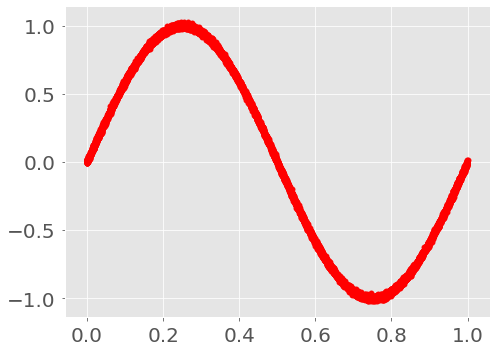

In [ ]:
# Initialize Experiment class
exp_class = ScaleExperiment(DataParams, ExpParams, )

# ========================================
# Step I - Extract data
# ========================================
dataset = 'sine'
noise = 0.01
seed = 123

X, Y = exp_class._get_data(dataset=dataset, noise=noise, seed=seed)

plot_data(X,Y)

# ========================================
# Step IV - Estimate mutual information
# ========================================
mi = exp_class._apply_mi_estimate(X, Y)

print(f'MI (RBIG): {mi:.4f}')

# ========================================
# Step II - Apply Scaling
# ========================================
scale = 10.

X = exp_class._apply_scaling(X=X, scale=scale)
plot_data(X,Y)

# ========================================
# Step III - Apply Normalization
# ========================================
normalize = True

X, Y = exp_class._apply_normalization(X=X, Y=Y, normalize=normalize)

plot_data(X,Y)



# ========================================
# Step V - Estimate HSIC value
# ========================================
method = 'hsic'
gamma_init = ('median', 0.5, None)
each_length = True

hsic_value = exp_class._apply_hsic_estimate(
    X, Y, 
    method=method, 
    gamma_init=gamma_init, 
    each_length=each_length
)

print(f'HSIC score ({method}): {hsic_value:.4f}')

#### Test Run - Experimental Step

In [11]:
class DataParams:
    num_points = 5_000
    noise_y = 0.1
    alpha = 1.0
    beta = 1.0

class ExpParams:
    dataset = [
        'line', 
        'sine', 
#         'circ',
#         'rand'
    ]
    seed = [1] #np.linspace(1,10,10)
    scale = np.logspace(-2, 2, 10)
    normalized = [
        True, 
        False
    ]
    noise = np.logspace(-3, 1, 10)
    method = [
        'hsic', 
        'tka', 
        'ctka'
    ]
    each_length = [
#         False, 
        True
    ]
    gamma_method = [
#         ('median', 0.2, None),
#         ('median', 0.4, None),
        ('median', 0.5, None),
#         ('median', 0.6, None),
#         ('median', 0.8, None),
    ]

In [12]:
# Initialize Experiment class
exp_class = ScaleExperiment(DataParams, ExpParams, )

results_df = pd.DataFrame()
results_df = exp_class._experiment_step(
    results_df=results_df,
    dataset=dataset, noise=noise, seed=seed,
    scale=scale,
    normalize=normalize,
    method=method,
    gamma_init=gamma_init
)

In [13]:
results_df.head()

,dataset,each,gamma_method,hsic_value,mi,noise,normalized,scale,scorer,trial
0,sine,0.0,median_p0.5,0.091784,3.355914,0.01,1.0,10.0,hsic,1.0


#### Test Run - Full Experiment Loop

In [14]:
class DataParams:
    num_points = 1_000
    noise_y = 0.1
    alpha = 1.0
    beta = 1.0

class ExpParams:
    dataset = [
        'line', 
        'sine', 
#         'circ',
#         'rand'
    ]
    seed = [1] #np.linspace(1,10,10)
    scale = np.logspace(-2, 2, 10)
    normalized = [
        True, 
        False
    ]
    noise = np.logspace(-3, 1, 10)
    method = [
        'hsic', 
        'tka', 
        'ctka'
    ]
    each_length = [False, True]
    gamma_method = [
#         ('median', 0.2, None),
#         ('median', 0.4, None),
        ('median', 0.5, None),
#         ('median', 0.6, None),
#         ('median', 0.8, None),
    ]

# Initialize Experiment class
exp_class = ScaleExperiment(DataParams, ExpParams, )

results_df = exp_class.run_experiment()

In [15]:
results_df.tail()

,dataset,each,gamma_method,hsic_value,mi,noise,normalized,scale,scorer,trial
2395,sine,0.0,median_p0.5,0.194763,0.0,10.0,0.0,100.0,tka,1.0
2396,sine,0.0,median_p0.5,0.008053,0.0,10.0,0.0,100.0,ctka,1.0
2397,sine,1.0,median_p0.5,0.000585,0.0,10.0,0.0,100.0,hsic,1.0
2398,sine,1.0,median_p0.5,0.673256,0.0,10.0,0.0,100.0,tka,1.0
2399,sine,1.0,median_p0.5,0.006027,0.0,10.0,0.0,100.0,ctka,1.0


## Cases - Walkthrough

In [21]:
def get_params(case: int):

    # Case I - Unscaled, Unnormalized
    if case == 1:

        class DataParams:
            num_points = 2_000
            noise_y = 0.0
            alpha = 1.0
            beta = 1.0

        class ExpParams:
            dataset = [
                "line",
                "sine",
                "circ",
                # "rand"
            ]
            seed = np.linspace(1, 10, 10, dtype=int)
            scale = [1.0]
            normalized = [False]
            noise = np.logspace(-2, 1, 10)
            method = ["hsic", "tka", "ctka"]
            gamma_method = [
                ("median", 0.2, None),
                ("median", 0.4, None),
                ("median", 0.5, None),
                ("median", 0.6, None),
                ("median", 0.8, None),
            ]

    # Case II - Unscaled, Normalized
    elif case == 2:

        class DataParams:
            num_points = 2_000
            noise_y = 0.0
            alpha = 1.0
            beta = 1.0

        class ExpParams:
            dataset = [
                "line",
                "sine",
                "circ",
                # "rand"
            ]
            seed = np.linspace(1, 10, 10, dtype=int)
            scale = [1.0]
            normalized = [True]
            noise = np.logspace(-2, 1, 10)
            method = ["hsic", "tka", "ctka"]
            gamma_method = [
                ("median", 0.2, None),
                ("median", 0.4, None),
                ("median", 0.5, None),
                ("median", 0.6, None),
                ("median", 0.8, None),
            ]

    # Case III - Scaled, Unnormalized
    elif case == 3:

        class DataParams:
            num_points = 2_000
            noise_y = 0.01
            alpha = 1.0
            beta = 1.0

        class ExpParams:
            dataset = [
                "line",
                "sine",
                "circ",
                # "rand",
            ]
            seed = np.linspace(1, 10, 10, dtype=int)
            scale = np.logspace(-2, 2, 10)
            normalized = [False]
            noise = np.logspace(-2, 1, 10)
            method = ["hsic", "tka", "ctka"]
            gamma_method = [
                ("median", 0.2, None),
                ("median", 0.4, None),
                ("median", 0.5, None),
                ("median", 0.6, None),
                ("median", 0.8, None),
            ]

    elif case == 4:

        class DataParams:
            dataset = "line"
            num_points = 2_000
            noise_y = 0.01
            alpha = 1.0
            beta = 1.0

        class ExpParams:
            dataset = [
                "line",
                "sine",
                "circ",
                # "rand"
            ]
            seed = np.linspace(1, 10, 10, dtype=int)
            scale = np.logspace(-2, 2, 10)  # [0.01, 1.0, 100.0]
            normalized = [True]
            noise = np.logspace(-3, 1, 10)
            method = ["hsic", "tka", "ctka"]
            gamma_method = [
                ("median", 0.2, None),
                ("median", 0.4, None),
                ("median", 0.5, None),
                ("median", 0.6, None),
                ("median", 0.8, None),
            ]

    else:
        raise ValueError(f"Unrecognized case: '{case}'")

    return DataParams, ExpParams

#### Case I - Unscaled, Unnormalized

For this first walkthrough, we are assuming that the data is unscaled and that the data is unnormalized. 

**Hypothesis**: We all methods should showcase some relationship to the amount of Mutual information but it will not necessarily be a strict relationship. Thinking from the previous results, the KA method should perform the worst, the HSIC method should perform OK with some inconsistencies and the CKA should perform the best and showcase a trend.

In [ ]:
# case number
case = 1

# get parameters
DataParams, ExpParams = get_params(case=case)

# Initialize Experiment class
exp_class = ScaleExperiment(DataParams, ExpParams, )

results_df = exp_class.run_experiment()

In [94]:
results_df

,dataset,gamma_method,hsic_value,mi,noise,normalized,scale,scorer,trial
0,line,median_p0.5,0.110588,3.094753,0.01,0.0,1.0,hsic,1.0
1,line,median_p0.5,0.999366,3.094753,0.01,0.0,1.0,tka,1.0
2,line,median_p0.5,0.998172,3.094753,0.01,0.0,1.0,ctka,1.0
3,line,median_p0.5,0.105917,3.074389,0.01,0.0,1.0,hsic,2.0
4,line,median_p0.5,0.999368,3.074389,0.01,0.0,1.0,tka,2.0
5,line,median_p0.5,0.998062,3.074389,0.01,0.0,1.0,ctka,2.0
6,line,median_p0.5,0.110391,3.111298,0.01,0.0,1.0,hsic,3.0
7,line,median_p0.5,0.999400,3.111298,0.01,0.0,1.0,tka,3.0
8,line,median_p0.5,0.998244,3.111298,0.01,0.0,1.0,ctka,3.0


#### Case II - Unscaled, Normalized

In this case, we see that

In [102]:
# case number
case = 2

# get parameters
DataParams, ExpParams = get_params(case=case)

# Initialize Experiment class
exp_class = ScaleExperiment(DataParams, ExpParams, )

# Run experiment
results_df = exp_class.run_experiment()

In [103]:
results_df

,dataset,gamma_method,hsic_value,mi,noise,normalized,scale,scorer,trial
0,line,median_p0.5,0.110589,3.094753,0.01,1.0,1.0,hsic,1.0
1,line,median_p0.5,0.999366,3.094753,0.01,1.0,1.0,tka,1.0
2,line,median_p0.5,0.998172,3.094753,0.01,1.0,1.0,ctka,1.0
3,line,median_p0.5,0.089667,1.011999,0.10,1.0,1.0,hsic,1.0
4,line,median_p0.5,0.946835,1.011999,0.10,1.0,1.0,tka,1.0
5,line,median_p0.5,0.843181,1.011999,0.10,1.0,1.0,ctka,1.0
6,line,median_p0.5,0.003926,0.043903,1.00,1.0,1.0,hsic,1.0
7,line,median_p0.5,0.686470,0.043903,1.00,1.0,1.0,tka,1.0
8,line,median_p0.5,0.040370,0.043903,1.00,1.0,1.0,ctka,1.0


#### Case III - Scaled, Unormalized

In [108]:
# case number
case = 3

# get parameters
DataParams, ExpParams = get_params(case=case)

# Initialize Experiment class
exp_class = ScaleExperiment(DataParams, ExpParams, )

# Run Experiment
results_df = exp_class.run_experiment()

In [109]:
results_df

,dataset,gamma_method,hsic_value,mi,noise,normalized,scale,scorer,trial
0,line,median_p0.5,1.109297e-04,3.094753,0.01,0.0,0.01,hsic,1.0
1,line,median_p0.5,6.316801e-01,3.094753,0.01,0.0,0.01,tka,1.0
2,line,median_p0.5,6.369142e-01,3.094753,0.01,0.0,0.01,ctka,1.0
3,line,median_p0.5,1.105885e-01,3.094753,0.01,0.0,1.00,hsic,1.0
4,line,median_p0.5,9.993656e-01,3.094753,0.01,0.0,1.00,tka,1.0
5,line,median_p0.5,9.981718e-01,3.094753,0.01,0.0,1.00,ctka,1.0
6,line,median_p0.5,1.099729e-04,3.094753,0.01,0.0,100.00,hsic,1.0
7,line,median_p0.5,6.323451e-01,3.094753,0.01,0.0,100.00,tka,1.0
8,line,median_p0.5,6.371835e-01,3.094753,0.01,0.0,100.00,ctka,1.0
9,line,median_p0.5,8.439792e-05,0.963049,0.10,0.0,0.01,hsic,1.0


#### Case IV - Scaled, Normalized

In [106]:
# case number
case = 4

# get parameters
DataParams, ExpParams = get_params(case=case)

# Initialize Experiment class
exp_class = ScaleExperiment(DataParams, ExpParams, )

# Run Experiment
results_df = exp_class.run_experiment()

In [107]:
results_df

,dataset,gamma_method,hsic_value,mi,noise,normalized,scale,scorer,trial
0,line,median_p0.5,0.110589,3.094753,0.01,1.0,0.01,hsic,1.0
1,line,median_p0.5,0.999366,3.094753,0.01,1.0,0.01,tka,1.0
2,line,median_p0.5,0.998172,3.094753,0.01,1.0,0.01,ctka,1.0
3,line,median_p0.5,0.110589,3.094753,0.01,1.0,1.00,hsic,1.0
4,line,median_p0.5,0.999366,3.094753,0.01,1.0,1.00,tka,1.0
5,line,median_p0.5,0.998172,3.094753,0.01,1.0,1.00,ctka,1.0
6,line,median_p0.5,0.110589,3.094753,0.01,1.0,100.00,hsic,1.0
7,line,median_p0.5,0.999366,3.094753,0.01,1.0,100.00,tka,1.0
8,line,median_p0.5,0.998172,3.094753,0.01,1.0,100.00,ctka,1.0
9,line,median_p0.5,0.089667,1.036774,0.10,1.0,0.01,hsic,1.0
